In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import fnmatch
import sys
import h5py
import pickle
import pandas as pd
from typing import Dict, List, Any, Tuple
from tqdm import tqdm
import torch 


from scipy.spatial import distance

import warnings # highly illegal move to make pandas compliant
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path

import utils_data, utils_spikes, utils_events

# Now that we have seen that the network is learning, it's time to create a dataloader to send this to PyTorch

In [3]:
# Parameters 
chip_id = 9501 # experiment ID
chip_session = 0 # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 10 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

In [4]:
# Loading data and getting the spikes
full_data = utils_data.read_maxwell_h5(data_path)

data = utils_data.Get_channel_spiketimes(full_data)
data['session'] = data['session'].map(str)
data['id'] = data[['chip_id', 'session', 'date']].agg('-'.join, axis=1)
data["session"] = pd.to_numeric(data["session"])

subset = data[(data['chip_id'] == str(chip_id)) & (data['session'] == chip_session)]

# Loading events
filename = utils_events. find_file(data_path, str(chip_id), str(chip_session))
events = utils_events.load_event_txt(filename)

Loading data...: 100%|██████████| 29/29 [00:01<00:00, 25.79it/s]


Stimulation mode: full game


In [5]:
# Extracting the spike times into a list and converting to seconds
spiketimes_list = []
for i in range(array_size) :
    spiketimes = subset['spike_times'].iloc[0]['channel_'+str(i)]
    spiketimes_list.append(spiketimes.to_numpy()/fs)

In [6]:
# Extracting the electrode mapping 
xs = subset['x_coordinates'].iloc[0]
ys = subset['y_coordinates'].iloc[0]

chan_idx = [int(x.split('_')[1]) for x in xs.keys()]
chan_xs = np.asarray(list(xs.values()))
chan_ys = np.asarray(list(ys.values()))
#spiketimes_array = np.asarray(spiketimes_list, dtype = object)

coo_array = np.vstack((chan_idx, chan_xs, chan_ys)).swapaxes(0,1) # this is linear in chan_idx space
rows_with_nan = np.isnan(coo_array).any(axis=1) # given above's linearity, this gives chan_idx with nans

# Delete electrodes without localization, also delete the spiketimes of these electrodes
coo_array = coo_array[~rows_with_nan]
spiketimes_list = np.asarray(spiketimes_list, dtype = object)[~rows_with_nan]

# Splitting sensory-motor on y axis
y_halfway = np.max(coo_array[:,2])/2

sensory_idx = coo_array[:, 2] <= y_halfway
motor_idx = coo_array[:, 2] > y_halfway

sensory_coo = coo_array[sensory_idx]
motor_coo = coo_array[motor_idx]
sensory_spikes = spiketimes_list[sensory_idx]
motor_spikes = spiketimes_list[motor_idx]


In [7]:
# Define the halfway point on the x-axis in the motor region
x_halfway_motor = np.max(motor_coo[:, 1])/2

# Define indices to split the motor region into left and right
left_idx = motor_coo[:, 1] <= x_halfway_motor
right_idx = motor_coo[:, 1] > x_halfway_motor

# Split motor_coo into left and right regions
left_coo = motor_coo[left_idx]
right_coo = motor_coo[right_idx]

# Split motor_spikes into left and right regions
left_spikes = motor_spikes[left_idx]
right_spikes = motor_spikes[right_idx]


# Define the halfway point on the x-axis for the left region
x_halfway_left = (np.min(left_coo[:, 1]) + np.max(left_coo[:, 1]))/2

# Define indices to split the left region into up and down
up1_idx = left_coo[:, 1] <= x_halfway_left
down1_idx = left_coo[:, 1] > x_halfway_left

# Split left_coo into up1 and down1 regions
up1_coo = left_coo[up1_idx]
down1_coo = left_coo[down1_idx]

# Split left_spikes into up1 and down1 regions
up1_spikes = left_spikes[up1_idx]
down1_spikes = left_spikes[down1_idx]


# Define the halfway point on the x-axis for the right region
x_halfway_right = (np.min(right_coo[:, 1]) + np.max(right_coo[:, 1]))/2

# Define indices to split the right region into up and down
up2_idx = right_coo[:, 1] <= x_halfway_right
down2_idx = right_coo[:, 1] > x_halfway_right

# Split right_coo into up2 and down2 regions
up2_coo = right_coo[up2_idx]
down2_coo = right_coo[down2_idx]

# Split right_spikes into up2 and down2 regions
up2_spikes = right_spikes[up2_idx]
down2_spikes = right_spikes[down2_idx]


# Just some sanity check

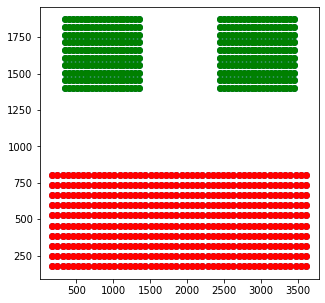

In [8]:
fig, ax = plt.subplots(figsize = (5,5))
plt.scatter(coo_array[:,1]  , coo_array[:,2])
plt.scatter(sensory_coo[:,1]  , sensory_coo[:,2], c = 'r')
plt.scatter(motor_coo[:,1]  , motor_coo[:,2], c = 'g')

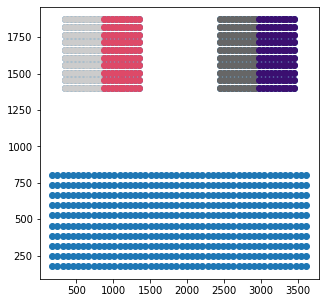

In [9]:
fig, ax = plt.subplots(figsize = (5,5))
plt.scatter(coo_array[:,1]  , coo_array[:,2])
map_up = plt.cm.gray(np.linspace(.4, .8, 2))
plt.scatter(up2_coo[:,1]  , up2_coo[:,2], color = map_up[0])
plt.scatter(up1_coo[:,1]  , up1_coo[:,2], color = map_up[1])
# same but for down coo 
map_down = plt.cm.magma(np.linspace(.2, .6, 2))
plt.scatter(down2_coo[:,1]  , down2_coo[:,2], color = map_down[0])
plt.scatter(down1_coo[:,1]  , down1_coo[:,2], color = map_down[1])

# Now we bin and torch them

In [10]:
# Function to convert list of spike times to bins
def spike_times_to_bins(spike_times_list, bin_width_ms, max_time_ms, spike_tag):
    bin_edges = np.arange(0, max_time_ms + bin_width_ms, bin_width_ms)
    binned_spikes = []
    for spikes in tqdm(spike_times_list, 'Binning %s channels' % spike_tag):
        # Convert spike times to milliseconds and compute histogram
        spikes_ms = spikes * 1000
        counts, _ = np.histogram(spikes_ms, bins=bin_edges)
        binned_spikes.append(counts)
    # Convert to tensor
    return torch.tensor(binned_spikes)

# Find maximum time across all spike lists
max_time_ms = max(max(max(spikes) for spikes in spike_list)*1000 for spike_list in [sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes])

# Create binned spikes tensor for each region
sensory_spikes_binned = spike_times_to_bins(sensory_spikes, 10, max_time_ms, spike_tag = 'sensory')
up1_spikes_binned = spike_times_to_bins(up1_spikes, 10, max_time_ms, spike_tag = 'up1')
down1_spikes_binned = spike_times_to_bins(down1_spikes, 10, max_time_ms, spike_tag='down1')
up2_spikes_binned = spike_times_to_bins(up2_spikes, 10, max_time_ms, spike_tag = 'up2')
down2_spikes_binned = spike_times_to_bins(down2_spikes, 10, max_time_ms, spike_tag = 'down2')

Binning sensory channels:   0%|          | 0/500 [00:00<?, ?it/s]

Binning sensory channels: 100%|██████████| 500/500 [00:00<00:00, 506.42it/s]
C:\Users\skorm\AppData\Local\Temp\ipykernel_20268\1471344466.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.tensor(binned_spikes)
Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 519.01it/s]


In [11]:
# Define a function to check for values greater than 1
def check_max_value(tensor, name):
    if torch.max(tensor) > 1:
        print(f"The {name} tensor contains a value greater than one.")
    else:
        print(f"The {name} tensor does not contain a value greater than one.")

# Check each tensor
check_max_value(sensory_spikes_binned, "sensory_spikes_binned")
check_max_value(up1_spikes_binned, "up1_spikes_binned")
check_max_value(down1_spikes_binned, "down1_spikes_binned")
check_max_value(up2_spikes_binned, "up2_spikes_binned")
check_max_value(down2_spikes_binned, "down2_spikes_binned")

The sensory_spikes_binned tensor does not contain a value greater than one.
The up1_spikes_binned tensor does not contain a value greater than one.
The down1_spikes_binned tensor does not contain a value greater than one.
The up2_spikes_binned tensor does not contain a value greater than one.
The down2_spikes_binned tensor does not contain a value greater than one.


# Grape, now we pass everything into a function

In [12]:
# Parameters 
chip_id = 9501 # experiment ID
chip_session = 0 # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 10 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

In [13]:
def load_file(chip_id, chip_session, data_path) :
    # Loading data and getting the spikes
    full_data = utils_data.read_maxwell_h5(data_path)

    data = utils_data.Get_channel_spiketimes(full_data)
    data['session'] = data['session'].map(str)
    data['id'] = data[['chip_id', 'session', 'date']].agg('-'.join, axis=1)
    data["session"] = pd.to_numeric(data["session"])

    subset = data[(data['chip_id'] == str(chip_id)) & (data['session'] == chip_session)]

    # Loading events
    filename = utils_events. find_file(data_path, str(chip_id), str(chip_session))
    events = utils_events.load_event_txt(filename)
    
    return subset, events

In [14]:
def get_spiketimes(data, array_size) :
    # Extracting the spike times into a list and converting to seconds
    spiketimes_list = []
    for i in range(array_size) :
        spiketimes = data['spike_times'].iloc[0]['channel_'+str(i)]
        spiketimes_list.append(spiketimes.to_numpy()/fs)
        
    return np.asarray(spiketimes_list, dtype=object)

In [15]:
def get_electrode_regions(data, spiketimes, do_plot = False) :
    # Extracting the electrode mapping 
    xs = data['x_coordinates'].iloc[0]
    ys = data['y_coordinates'].iloc[0]

    chan_idx = [int(x.split('_')[1]) for x in xs.keys()]
    chan_xs = np.asarray(list(xs.values()))
    chan_ys = np.asarray(list(ys.values()))
    #spiketimes_array = np.asarray(spiketimes_list, dtype = object)

    coo_array = np.vstack((chan_idx, chan_xs, chan_ys)).swapaxes(0,1) # this is linear in chan_idx space
    rows_with_nan = np.isnan(coo_array).any(axis=1) # given above's linearity, this gives chan_idx with nans

    # Delete electrodes without localization, also delete the spiketimes of these electrodes
    coo_array = coo_array[~rows_with_nan]
    spiketimes = spiketimes[~rows_with_nan]

    # Splitting sensory-motor on y axis
    y_halfway = np.max(coo_array[:,2])/2

    sensory_idx = coo_array[:, 2] <= y_halfway
    motor_idx = coo_array[:, 2] > y_halfway

    sensory_coo = coo_array[sensory_idx]
    motor_coo = coo_array[motor_idx]
    sensory_spikes = spiketimes[sensory_idx]
    motor_spikes = spiketimes[motor_idx]

    # Define the halfway point on the x-axis in the motor region
    x_halfway_motor = np.max(motor_coo[:, 1])/2

    # Define indices to split the motor region into left and right
    left_idx = motor_coo[:, 1] <= x_halfway_motor
    right_idx = motor_coo[:, 1] > x_halfway_motor

    # Split motor_coo into left and right regions
    left_coo = motor_coo[left_idx]
    right_coo = motor_coo[right_idx]

    # Split motor_spikes into left and right regions
    left_spikes = motor_spikes[left_idx]
    right_spikes = motor_spikes[right_idx]


    # Define the halfway point on the x-axis for the left region
    x_halfway_left = (np.min(left_coo[:, 1]) + np.max(left_coo[:, 1]))/2

    # Define indices to split the left region into up and down
    up1_idx = left_coo[:, 1] <= x_halfway_left
    down1_idx = left_coo[:, 1] > x_halfway_left

    # Split left_coo into up1 and down1 regions
    up1_coo = left_coo[up1_idx]
    down1_coo = left_coo[down1_idx]

    # Split left_spikes into up1 and down1 regions
    up1_spikes = left_spikes[up1_idx]
    down1_spikes = left_spikes[down1_idx]


    # Define the halfway point on the x-axis for the right region
    x_halfway_right = (np.min(right_coo[:, 1]) + np.max(right_coo[:, 1]))/2

    # Define indices to split the right region into up and down
    up2_idx = right_coo[:, 1] <= x_halfway_right
    down2_idx = right_coo[:, 1] > x_halfway_right

    # Split right_coo into up2 and down2 regions
    up2_coo = right_coo[up2_idx]
    down2_coo = right_coo[down2_idx]

    # Split right_spikes into up2 and down2 regions
    up2_spikes = right_spikes[up2_idx]
    down2_spikes = right_spikes[down2_idx]
    
    # Sanity plot 
    if do_plot :
        fig, ax = plt.subplots(figsize = (5,5))
        map_up = plt.cm.gray(np.linspace(.4, .8, 2))
        ax.scatter(up2_coo[:,1]  , up2_coo[:,2], color = map_up[0], label = 'up2')
        ax.scatter(up1_coo[:,1]  , up1_coo[:,2], color = map_up[1], label = 'up1')
        # same but for down coo 
        map_down = plt.cm.magma(np.linspace(.2, .6, 2))
        ax.scatter(down2_coo[:,1]  , down2_coo[:,2], color = map_down[0], label = 'down2')
        ax.scatter(down1_coo[:,1]  , down1_coo[:,2], color = map_down[1], label = 'down1')
        ax.scatter(sensory_coo[:,1]  , sensory_coo[:,2], color = 'b', label = 'sensory')
        plt.legend()
        plt.title('Sanity check of the extracted electrode mapping')
        plt.show()

    return sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes

In [16]:
def spike_times_to_bins(spike_times_list, bin_width_ms, max_time_ms, spike_tag):
    bin_edges = np.arange(0, max_time_ms + bin_width_ms, bin_width_ms)
    binned_spikes = []
    for spikes in tqdm(spike_times_list, 'Binning %s channels' % spike_tag):
        # Convert spike times to milliseconds and compute histogram
        spikes_ms = spikes * 1000
        counts, _ = np.histogram(spikes_ms, bins=bin_edges)
        binned_spikes.append(counts)
    # Convert to tensor
    return torch.tensor(binned_spikes)

In [17]:
def check_binary(spike_tensor, name) :
    if torch.max(spike_tensor) > 1:
        raise ValueError('The tensor {} is not binary'.format(name))
    else:
        return True

In [18]:
data_subset, events = load_file(chip_id, chip_session, data_path)

Loading data...: 100%|██████████| 29/29 [00:01<00:00, 22.53it/s]


Stimulation mode: full game


In [19]:
spiketimes = get_spiketimes(data_subset, array_size)

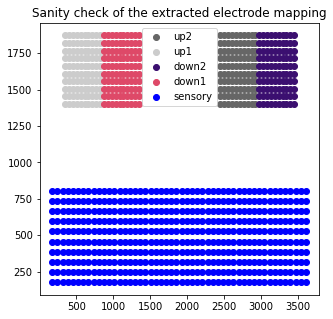

In [20]:
sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes = get_electrode_regions(data_subset, spiketimes, do_plot = True)

In [21]:
# Find maximum time across all spike lists
max_time_ms = max(max(max(spikes) for spikes in spike_list)*1000 for spike_list in [sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes])

# Create binned spikes tensor for each region
sensory_spikes_binned = spike_times_to_bins(sensory_spikes, 10, max_time_ms, spike_tag = 'sensory')
up1_spikes_binned = spike_times_to_bins(up1_spikes, 10, max_time_ms, spike_tag = 'up1')
down1_spikes_binned = spike_times_to_bins(down1_spikes, 10, max_time_ms, spike_tag='down1')
up2_spikes_binned = spike_times_to_bins(up2_spikes, 10, max_time_ms, spike_tag = 'up2')
down2_spikes_binned = spike_times_to_bins(down2_spikes, 10, max_time_ms, spike_tag = 'down2')

Binning sensory channels:   0%|          | 0/500 [00:00<?, ?it/s]

Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 670.81it/s]


In [22]:
check_binary(sensory_spikes_binned, "sensory_spikes_binned")
check_binary(up1_spikes_binned, "up1_spikes_binned")
check_binary(down1_spikes_binned, "down1_spikes_binned")
check_binary(up2_spikes_binned, "up2_spikes_binned")
check_binary(down2_spikes_binned, "down2_spikes_binned")

True